# Forward Correlation
Creates correlation of forward-forwards and volatility-volatility from daily historical data of forward rates

In [34]:
#load libraries
import pandas as pd
import numpy as np
from scipy import interpolate, stats, optimize
import matplotlib.pyplot as plt
from arch import arch_model
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import datetime
import matplotlib.dates as mdates
import os
import pickle

In [35]:
#load raw historical fwd data
with open(os.path.join(os.getcwd(), "raw_dataset", "forwardrates.csv")) as file:
    raw_fwd = pd.read_csv(file)

path_output = os.path.join(os.getcwd(), "parameters")


raw_fwd["Date"] = pd.to_datetime(raw_fwd["Date"], utc = False)
raw_fwd = raw_fwd[raw_fwd["Date"] >= "11/1/2019"]

In [36]:
raw_fwd.head()

,Unnamed: 0,Date,f_6m,f_12m,f_18m,f_24m,f_30m,f_36m,f_42m,f_48,...,f_66m,f_72m,f_78m,f_84m,f_90m,f_96m,f_102m,f_108m,f_114m,f_120m
1210,1211,2019-11-01,1.604555,1.564917,1.540327,1.528943,1.529086,1.539226,1.557974,1.584067,...,1.695525,1.740614,1.788337,1.838014,1.889037,1.940864,1.993011,2.045053,2.096611,2.147355
1211,1212,2019-11-04,1.627432,1.600301,1.585662,1.582076,1.588216,1.602861,1.624889,1.653272,...,1.767509,1.812651,1.860181,1.909504,1.960084,2.011434,2.063119,2.114745,2.165962,2.216457
1212,1213,2019-11-05,1.650595,1.639593,1.638482,1.646105,1.661391,1.683356,1.711091,1.743764,...,1.864071,1.909462,1.956563,2.004890,2.054003,2.103504,2.153035,2.202272,2.250927,2.298743
1213,1214,2019-11-06,1.633410,1.616529,1.610260,1.613382,1.624770,1.643388,1.668280,1.698567,...,1.814061,1.858508,1.904944,1.952854,2.001773,2.051278,2.100988,2.150560,2.199686,2.248092
1214,1215,2019-11-07,1.675669,1.686368,1.702485,1.723409,1.748573,1.777449,1.809545,1.844406,...,1.961492,2.003478,2.046405,2.089989,2.133968,2.178103,2.222174,2.265980,2.309341,2.352089


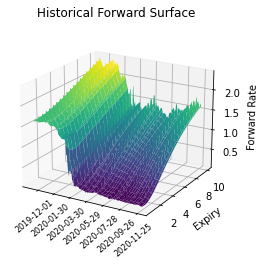

In [37]:
#historical surface plot
date =  mdates.date2num(np.array(raw_fwd["Date"]))

x = date.reshape(-1,1)
y = np.arange(1, 21)/2 #expiries
X, Y = np.meshgrid(x, y)
z = np.array(raw_fwd.drop(["Date", "Unnamed: 0"], axis = 1)).T

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, z, cmap = cm.viridis)
ax.set_title("Historical Forward Surface")
ax.set_ylabel("Expiry")
ax.set_zlabel("Forward Rate")
ax.set_xlabel("")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval= 60))
plt.xticks(rotation = 40,  fontsize =8)
ax.tick_params(axis = 'x', pad = -2.5)
ax.view_init(20, 300)


In [38]:
#forward-forward correlation
fwd_mat = np.array(raw_fwd.drop(["Date", "Unnamed: 0"], axis = 1))

#changes in forward
fwd_mat_chg = np.apply_along_axis(lambda x: np.diff(x)/x[:-1], 0, fwd_mat)

corr_chg = np.corrcoef(fwd_mat_chg.T)

### Estimate volatility-volatility 2 methods
1. Rolling non-overlapping fixed window
2. GARCH

In [39]:
# =============================================================================
# estimate volvol - method 1: step-wise
# =============================================================================
# divide by buckets and estimate volatility per bucket
# making sure excess kurtosis is close to 0
numbuckets = 50
upper_idx = np.arange(0, fwd_mat.shape[0]+1, step =  fwd_mat.shape[0]/numbuckets)
idx_ranges = [[int(upper_idx[i-1]), int(upper_idx[i])] for i in range(1, len(upper_idx))]

vol_ts = np.zeros((len(idx_ranges), fwd_mat.shape[1])) #stepwise
vol_kurtosis = np.zeros_like(vol_ts)
for i in range(len(idx_ranges)):
    temp_volbucket = fwd_mat[idx_ranges[i][0]:idx_ranges[i][1], :]
    ts_volbucket = np.apply_along_axis(lambda x: np.diff(x)/x[:-1], 0, temp_volbucket) #calculate mean returns
    ts_volbucket_std = (ts_volbucket)/np.std(ts_volbucket, axis = 0) #standardize
    vol_kurtosis[i, :] = stats.kurtosis(ts_volbucket, axis = 0)
    vol_ts[i, :] = np.std(ts_volbucket, axis = 0)
    
volvol_corr = np.corrcoef(vol_ts.T)

In [40]:
%%capture
# =============================================================================
# estimate volvol - method 2: garch
# =============================================================================
vol_garch_ts = np.zeros_like(fwd_mat_chg)
for i in range(fwd_mat_chg.shape[1]):
    model = arch_model(fwd_mat_chg[:, i], mean='Zero', vol='GARCH', p=1, q=1, rescale = False)
    fit= model.fit()
    vol_garch_ts[:, i] = fit.conditional_volatility

volvol_corr_garch = np.corrcoef(vol_garch_ts.T)

### Define 1 parameter Doust correlation structures functions

In [41]:
# =============================================================================
# parametrization with doust
# =============================================================================

def doust_corr(beta, n):
    '''
    create nxn doust correlation with beta decay exponential
    n = # of semi-annual expiries
    '''
    tau = np.arange(1, n+1)/2
    a = np.exp(- beta / np.arange(1, len(tau[:-1])+1) )
    doust = np.zeros((n, n))
    dim = doust.shape
    for i in range(doust.shape[0]):
        for j in range(doust.shape[1]):
            if i == j:
                doust[i, j] = 1
            elif i > j:
                doust[i, j] = np.prod(a[j:i])
    #reflect
    doust[np.triu_indices(dim[0], 1)] = doust.T[np.triu_indices(dim[0], 1)]
    return(doust)



def calibrated_doust_eigen(target_corr):
    '''
    calibrate beta parameter for doust correlation by optimizing over the first 4 eigen values
    '''
    n =target_corr.shape[0]
    
    #optimize over sum of first 4 eigenvalues
    sol = optimize.minimize(lambda x: 
                        np.sum((np.linalg.eigvals(target_corr)[:4] - 
                                np.linalg.eigvals(doust_corr(x, n))[:4])**2), x0 = np.array([0.1]))
        
    calibrated_beta = sol.x
    return(doust_corr(calibrated_beta, n))


def calibrated_doust_element(target_mat):
    '''
    calibrate beta parameter for doust correlation by finding least squares of each matrix entry
    '''
    
    dim_mat =target_mat.shape
    
    target_entries = target_mat.ravel()
    def func_to_minimize(beta):
        residual = target_entries - doust_corr(beta, dim_mat[0]).ravel()
        return residual
    #optimize over sum of first 4 eigenvalues
    sol = optimize.least_squares(func_to_minimize,
            x0 = 0.1)
        
    calibrated_beta = sol.x
    return(doust_corr(calibrated_beta, dim_mat[0]))

In [42]:
#assume doust 1 parameter structure for the fwd-fwd and vol-vol correlation structures

doust_fwd_fwd = calibrated_doust_element(corr_chg)
doust_vol_vol = calibrated_doust_element(volvol_corr_garch)

In [43]:
#plotting helper
def plot_corr_mat(corr_mat):
    dim = corr_mat.shape
    x = np.arange(1, (dim[0]+1))/2
    y = x   

    X, Y = np.meshgrid(x, y)
    z = corr_mat

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, z, cmap = cm.gray)
    ax.view_init(20, 240)


Text(0.5, 0.92, 'Vol-Vol Doust Parametrization')

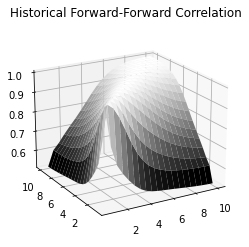

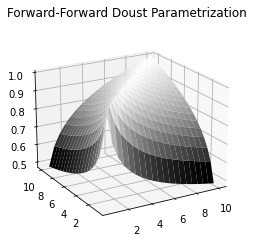

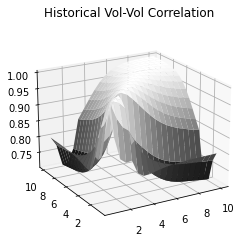

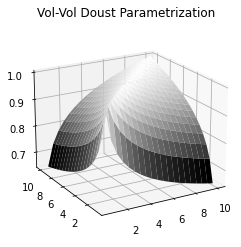

In [44]:
#plots
plot_corr_mat(corr_chg)
plt.title('Historical Forward-Forward Correlation')



plot_corr_mat(doust_fwd_fwd)
plt.title('Forward-Forward Doust Parametrization')



plot_corr_mat(volvol_corr_garch)
plt.title('Historical Vol-Vol Correlation')


plot_corr_mat(doust_vol_vol)
plt.title('Vol-Vol Doust Parametrization')

In [45]:
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

In [46]:
save_object(doust_fwd_fwd, path_output+"\\fwdfwd_corr.pkl")
save_object(doust_vol_vol, path_output+"\\volvol_corr.pkl")